# Tracing Basics

### Setup

Make sure you set your environment variables, including your OpenAI API key.

In [6]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv( override=True)

True

### Tracing with @traceable

The @traceable decorator is a simple way to log traces from the LangSmith Python SDK. Simply decorate any function with @traceable.

The decorator works by creating a run tree for you each time the function is called and inserting it within the current trace. The function inputs, name, and other information is then streamed to LangSmith. If the function raises an error or if it returns a response, that information is also added to the tree, and updates are patched to LangSmith so you can detect and diagnose sources of errors. This is all done on a background thread to avoid blocking your app's execution.

In [8]:
from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever
import os

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 

"""

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable
def retrieve_documents(question: str):
    return retriever.invoke(question)   # NOTE: This is a LangChain vector db retriever, so this .invoke() call will be traced automatically

@traceable
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )

@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question) # this call retrieves documents form a vector data base
    response = generate_response(question, documents)
    return response.choices[0].message.content



@traceable handles the RunTree lifecycle for you!

In [9]:
question = "How can I trace with the @traceable decorator?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To trace with the @traceable decorator in Python, you simply need to decorate any function you want to log traces for with the @traceable decorator. Here’s a basic example:

```python
from langsmith import traceable

@traceable
def your_function():
    # Your function logic here
    pass
```

Make sure that the `LANGSMITH_TRACING` environment variable is set to 'true' to enable tracing, and also set the `LANGSMITH_API_KEY` environment variable to your API key. This setup allows you to log traces to LangSmith with minimal changes to your existing code.



Run tree for above cell 

![picture1](assets/pic1.png)

# My example for testing above code 

In [10]:
question="In LangSmith, when analyzing multiple runs across different projects, you notice that some outputs are unexpectedly long or missing. Which table or entity would you examine to identify exactly which component or step caused the issue, and how does this help optimize complex LLM workflows?"
response=langsmith_rag(question)
print(response)

In LangSmith, to identify which component or step caused issues with unexpectedly long or missing outputs during multiple runs across different projects, you would examine the "LangSmith Traces." This entity tracks all traces sent to LangSmith and can provide insights into the performance of different components in your workflow. By analyzing these traces, you can pinpoint where delays or failures occur, allowing you to optimize complex LLM workflows by addressing specific bottlenecks or issues in the process. This targeted approach helps improve efficiency and output quality in your experiments.


Here is the run tree and 
We can see the input to our retrive documents function and the output ie the documents it retrived related to the question in the Run Tree

![picture1](assets/pic2.png)

##### Let's take a look in LangSmith!

### Adding Metadata

LangSmith supports sending arbitrary metadata along with traces.

Metadata is a collection of key-value pairs that can be attached to runs. Metadata can be used to store additional information about a run, such as the version of the application that generated the run, the environment in which the run was generated, or any other information that you want to associate with a run. Similar to tags, you can use metadata to filter runs in the LangSmith UI, and can be used to group runs together for analysis.

In [11]:
from langsmith import traceable

@traceable(
    metadata={"vectordb": "sklearn"}
)
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable(
    metadata={"model_name": MODEL_NAME, "model_provider": MODEL_PROVIDER}
)
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )

@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


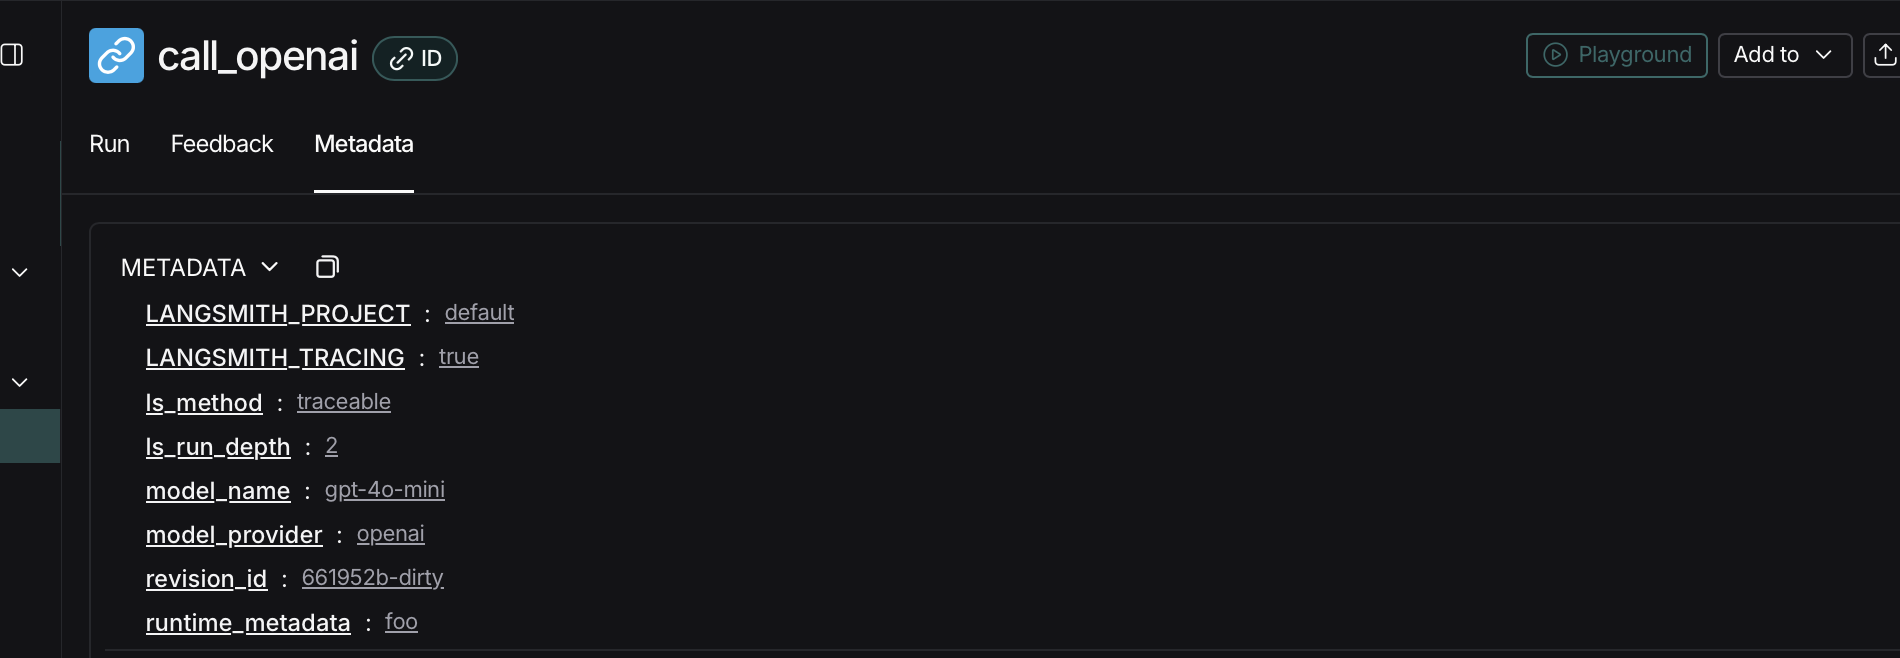

In [12]:
question = "How do I add Metadata to a Run with @traceable?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To add metadata to a run with `@traceable`, you can include a `metadata` key within the `experimental_telemetry` object when calling the `generateText` function. Here’s an example of how to do this:

```javascript
await generateText({
  model: openai("gpt-4.1-nano"),
  prompt: "Your prompt here.",
  experimental_telemetry: {
    isEnabled: true,
    metadata: { userId: "123", language: "english" }, // Add your metadata here
  },
});
```

This metadata will be visible in your LangSmith dashboard and can be used to filter and search for specific traces.


You can also add metadata at runtime!

In [13]:
question = "How do I add metadata at runtime?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"runtime_metadata": "foo"}})
print(ai_answer)

The context provided does not specify how to add metadata at runtime. It only describes how to add metadata to examples and experiments after they have been created. Therefore, I don't know how to add metadata at runtime.


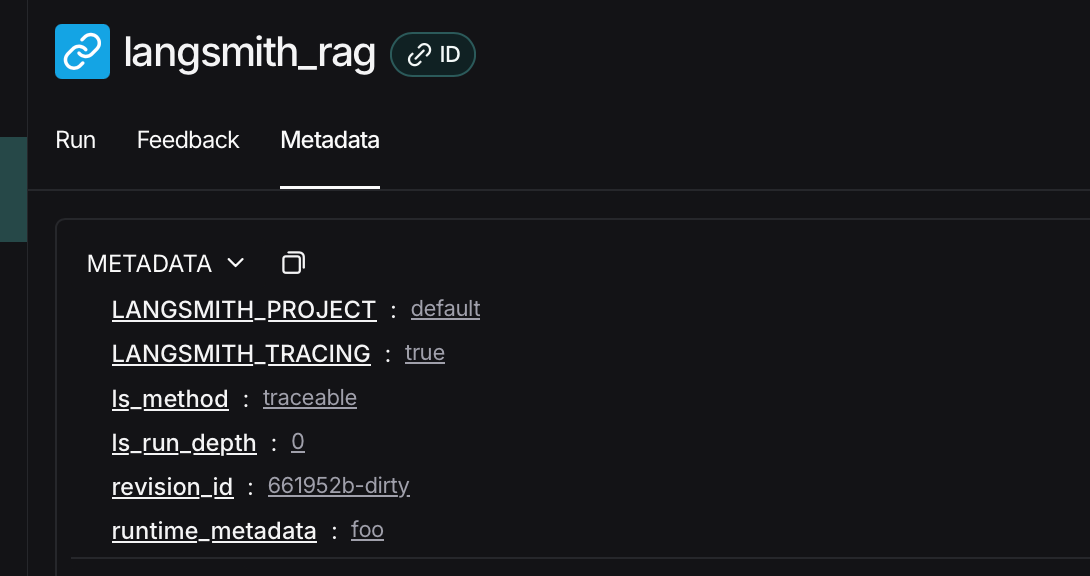

##### Let's take a look in LangSmith!